📂 Please upload your CSV file...


/tmp/ipython-input-5-3008029174.py:38: FutureWarning: Parsed string "Thu Jul 18 10:30:00 IST 2024" included an un-recognized timezone "IST". Dropping unrecognized timezones is deprecated; in a future version this will raise. Instead pass the string without the timezone, then use .tz_localize to convert to a recognized timezone.
  df['Date'] = pd.to_datetime(df['Date'], errors='coerce', dayfirst=True)
/tmp/ipython-input-5-3008029174.py:43: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  df = df.resample('1H').mean().interpolate()
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp_7s2zgmp/furv3rek.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp_7s2zgmp/1ugytxzw.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', '

Saving output_file.csv to output_file (3).csv
✅ Loaded file: output_file (3).csv


11:19:11 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
/usr/local/lib/python3.11/dist-packages/prophet/forecaster.py:1872: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  dates = pd.date_range(
/tmp/ipython-input-5-3008029174.py:62: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  residuals = merged[['ds', 'residual']].set_index('ds').resample('1H').mean().interpolate()
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/transformer.py:385: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(
INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zer

Training: |          | 0/? [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/torch/nn/modules/loss.py:610: UserWarning: Using a target size (torch.Size([1, 1, 183])) that is different to the input size (torch.Size([1, 183])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=50` reached.
/tmp/ipython-input-5-3008029174.py:175: UserWarning: Glyph 9989 (\N{WHITE HEAVY CHECK MARK}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 9989 (\N{WHITE HEAVY CHECK MARK}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


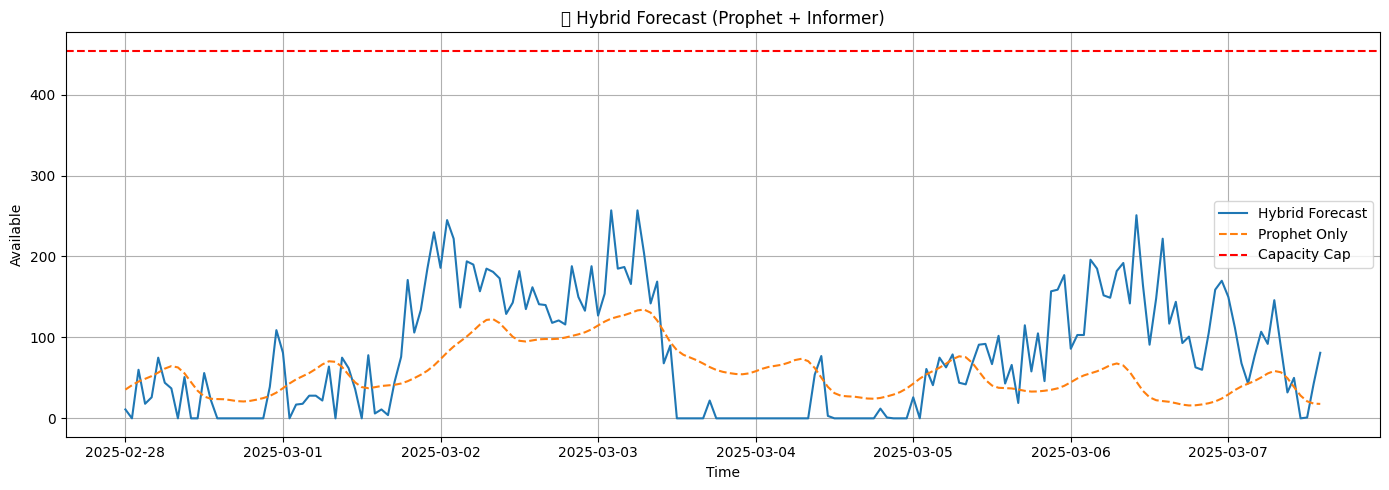

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

✅ Forecast saved to: prophet_informer_hybrid_forecast.csv


In [5]:
# ============================================================
# ✅ Colab: Hybrid Forecast (Prophet + Informer) - FIXED
# ============================================================

# Install dependencies
!pip install prophet scikit-learn matplotlib pandas torch einops pytorch-lightning --quiet

# ------------------------------------------------------------
# Imports
# ------------------------------------------------------------
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from prophet import Prophet
from sklearn.preprocessing import MinMaxScaler
from google.colab import files
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import pytorch_lightning as pl
from einops import rearrange

# ------------------------------------------------------------
# Upload CSV
# ------------------------------------------------------------
print("📂 Please upload your CSV file...")
uploaded = files.upload()
for fn in uploaded.keys():
    file_path = fn
print(f"✅ Loaded file: {file_path}")

# ------------------------------------------------------------
# Load data
# ------------------------------------------------------------
df = pd.read_csv(file_path)
df.columns = df.columns.str.strip()
df['Date'] = pd.to_datetime(df['Date'], errors='coerce', dayfirst=True)
df = df.dropna(subset=['Date']).sort_values('Date')
df = df[['Date', 'Available']].set_index('Date')

# Ensure hourly
df = df.resample('1H').mean().interpolate()

# ------------------------------------------------------------
# Prophet forecast
# ------------------------------------------------------------
df_prophet = df.reset_index().rename(columns={'Date': 'ds', 'Available': 'y'})
cap_value = df_prophet['y'].max() * 1.1
df_prophet['cap'] = cap_value

model = Prophet(growth='logistic', daily_seasonality=True)
model.fit(df_prophet)

future = model.make_future_dataframe(periods=183, freq='1H')
future['cap'] = cap_value
forecast = model.predict(future)

# Residuals
merged = pd.merge(df_prophet, forecast[['ds', 'yhat']], on='ds', how='inner')
merged['residual'] = merged['y'] - merged['yhat']
residuals = merged[['ds', 'residual']].set_index('ds').resample('1H').mean().interpolate()

# ------------------------------------------------------------
# Prepare residual data
# ------------------------------------------------------------
input_len = 168
forecast_len = 183
residual_values = residuals['residual'].values.reshape(-1, 1)

scaler = MinMaxScaler()
residual_scaled = scaler.fit_transform(residual_values)

X_seq = residual_scaled[-(input_len + forecast_len):-forecast_len]
y_seq = residual_scaled[-forecast_len:]

X_tensor = torch.tensor(X_seq, dtype=torch.float32)  # [168,1]
y_tensor = torch.tensor(y_seq.flatten(), dtype=torch.float32).unsqueeze(0)  # [1,183]

# ------------------------------------------------------------
# Dataset
# ------------------------------------------------------------
class ResidualDataset(Dataset):
    def __len__(self):
        return 1
    def __getitem__(self, idx):
        return X_tensor, y_tensor  # X: [168,1]

dataset = ResidualDataset()
loader = DataLoader(dataset, batch_size=1)

# ------------------------------------------------------------
# Informer with positional encoding
# ------------------------------------------------------------
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=5000):
        super().__init__()
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-np.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0)
        self.register_buffer('pe', pe)
    def forward(self, x):
        return x + self.pe[:, :x.size(1)]

class InformerBlock(pl.LightningModule):
    def __init__(self, forecast_len, d_model=64, n_heads=4, num_layers=2, ff_dim=128, dropout=0.1):
        super().__init__()
        self.input_proj = nn.Linear(1, d_model)
        self.pos_enc = PositionalEncoding(d_model)
        encoder_layer = nn.TransformerEncoderLayer(d_model=d_model, nhead=n_heads, dim_feedforward=ff_dim, dropout=dropout)
        self.encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)
        self.fc_out = nn.Linear(d_model, forecast_len)

    def forward(self, x):
        # x: [batch, seq_len, 1]
        x = self.input_proj(x)  # [batch, seq_len, d_model]
        x = self.pos_enc(x)
        x = rearrange(x, 'b t d -> t b d')  # [seq_len, batch, d_model]
        enc_out = self.encoder(x)
        enc_out = enc_out[-1]  # last time step
        return self.fc_out(enc_out)  # [batch, forecast_len]

    def training_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        return nn.MSELoss()(y_hat, y)


    def configure_optimizers(self):
        return optim.Adam(self.parameters(), lr=1e-3)

# ------------------------------------------------------------
# Train Informer
# ------------------------------------------------------------
model_informer = InformerBlock(forecast_len)
trainer = pl.Trainer(max_epochs=50, enable_checkpointing=False, logger=False, enable_progress_bar=True)
trainer.fit(model_informer, loader)

# ------------------------------------------------------------
# Predict
# ------------------------------------------------------------
model_informer.eval()
with torch.no_grad():
    X_input = X_tensor.unsqueeze(0)  # [1, seq_len, 1]
    pred_scaled = model_informer(X_input).numpy().flatten()
predicted_residuals = scaler.inverse_transform(pred_scaled.reshape(-1, 1)).flatten()

# ------------------------------------------------------------
# Combine with Prophet
# ------------------------------------------------------------
forecast_range = forecast.tail(forecast_len).copy()
hybrid_forecast = forecast_range['yhat'].values + predicted_residuals
hybrid_forecast = np.clip(hybrid_forecast, 0, cap_value)

final_df = pd.DataFrame({
    'Date': forecast_range['ds'].values,
    'Prophet': forecast_range['yhat'].values,
    'Residuals': predicted_residuals,
    'Hybrid_Available': hybrid_forecast.astype(int)
})

# Plot
plt.figure(figsize=(14, 5))
plt.plot(final_df['Date'], final_df['Hybrid_Available'], label='Hybrid Forecast')
plt.plot(final_df['Date'], final_df['Prophet'], label='Prophet Only', linestyle='--')
plt.axhline(cap_value, color='red', linestyle='--', label='Capacity Cap')
plt.title('✅ Hybrid Forecast (Prophet + Informer)')
plt.xlabel('Time')
plt.ylabel('Available')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Save
output_csv = "prophet_informer_hybrid_forecast.csv"
final_df.to_csv(output_csv, index=False)
files.download(output_csv)
print(f"✅ Forecast saved to: {output_csv}")


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 717.0/717.0 kB 10.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
📂 Please upload your ODS file (check.ods or cleaned version)...


Saving check.ods to check.ods

📂 Please upload your CSV file (prophet_informer_hybrid_forecast.csv or cleaned version)...


Saving prophet_informer_hybrid_forecast.csv to prophet_informer_hybrid_forecast (1).csv

✅ ODS File: check.ods
✅ CSV File: prophet_informer_hybrid_forecast (1).csv
✅ Loaded CSV with encoding='utf-8' and delimiter=','

📝 ODS Columns: ['Date', 'Total Node', 'In Use', 'Offline', 'Available']
📝 CSV Columns: ['Date', 'Prophet', 'Residuals', 'Available']


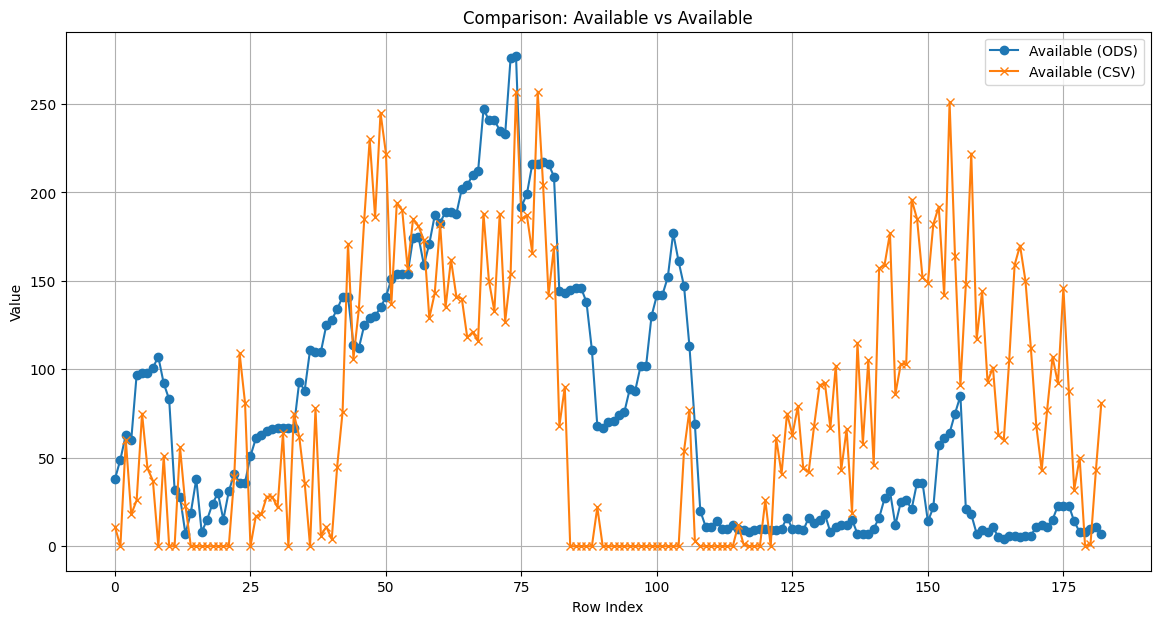

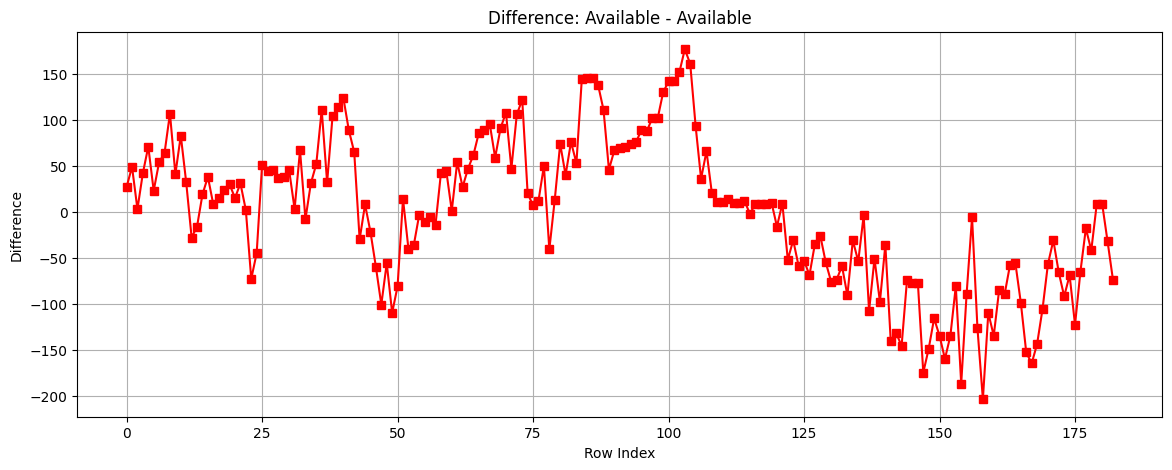


📊 First few differences:
0    27
1    49
2     3
3    42
4    71
Name: Available, dtype: int64

✅ Comparison saved as 'available_comparison_prophet_informer.csv'.


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [6]:
 # ============================================
# 📊 Compare 'Available' vs 'Hybrid_Available'
# ============================================

# STEP 1: Install required libraries
!pip install pandas odfpy matplotlib --quiet

# STEP 2: Import libraries
import pandas as pd
import matplotlib.pyplot as plt
from google.colab import files

# STEP 3: Upload files
print("📂 Please upload your ODS file (check.ods or cleaned version)...")
uploaded1 = files.upload()

print("\n📂 Please upload your CSV file (prophet_informer_hybrid_forecast.csv or cleaned version)...")
uploaded2 = files.upload()

# Get uploaded file names
ods_file = list(uploaded1.keys())[0]
csv_file = list(uploaded2.keys())[0]

print(f"\n✅ ODS File: {ods_file}")
print(f"✅ CSV File: {csv_file}")

# STEP 4: Load ODS
ods_df = pd.read_excel(ods_file, engine='odf') if ods_file.endswith('.ods') else pd.read_csv(ods_file)

# STEP 5: Load CSV with fallback
def load_csv(filename):
  for enc in ['utf-8', 'cp1252', 'ISO-8859-1']:
    for delim in [',', ';', '\t']:
      try:
        df = pd.read_csv(filename, encoding=enc, delimiter=delim, on_bad_lines='skip')
        print(f"✅ Loaded CSV with encoding='{enc}' and delimiter='{delim}'")
        return df
      except Exception:
        continue
  raise ValueError(f"❌ Could not load {filename}.")

csv_df = load_csv(csv_file)

# STEP 6: Clean columns
ods_df.columns = ods_df.columns.str.strip()
csv_df.columns = csv_df.columns.str.strip()

print("\n📝 ODS Columns:", list(ods_df.columns))
print("📝 CSV Columns:", list(csv_df.columns))

# STEP 7: Correct columns
ods_column = 'Available'
csv_column = 'Hybrid_Available' if 'Hybrid_Available' in csv_df.columns else 'Available'

# STEP 8: Extract & ensure numeric
available_ods = ods_df[ods_column].apply(pd.to_numeric, errors='coerce').dropna().reset_index(drop=True)
available_csv = csv_df[csv_column].apply(pd.to_numeric, errors='coerce').dropna().reset_index(drop=True)

# STEP 9: Align length
min_len = min(len(available_ods), len(available_csv))
available_ods = available_ods[:min_len]
available_csv = available_csv[:min_len]
difference = available_ods - available_csv

# STEP 10: Plot comparison
plt.figure(figsize=(14, 7))
plt.plot(available_ods, label=f'{ods_column} (ODS)', marker='o')
plt.plot(available_csv, label=f'{csv_column} (CSV)', marker='x')
plt.title(f"Comparison: {ods_column} vs {csv_column}")
plt.xlabel("Row Index")
plt.ylabel("Value")
plt.legend()
plt.grid(True)
plt.show()

# Plot difference
plt.figure(figsize=(14, 5))
plt.plot(difference, color='red', marker='s')
plt.title(f"Difference: {ods_column} - {csv_column}")
plt.xlabel("Row Index")
plt.ylabel("Difference")
plt.grid(True)
plt.show()

print("\n📊 First few differences:")
print(difference.head())

# STEP 11: Save results
comparison_df = pd.DataFrame({
    'ODS_Available': available_ods,
    'CSV_Hybrid_Available': available_csv,
    'Difference': difference
})
comparison_df.to_csv('available_comparison_prophet_informer.csv', index=False)
print("\n✅ Comparison saved as 'available_comparison_prophet_informer.csv'.")

# Optional: Download result
files.download('available_comparison_prophet_informer.csv')
